  0%|          | 14/143372 [00:00<00:02, 58023.97it/s]


path:  13/free_3_ID13/000849  already labeled
path:  15/free_1_ID15/001464  already labeled
path:  19/base_1_ID19/001380  already labeled
path:  20/base_2_ID20/001055  already labeled
path:  10/free_2_ID10/001106  already labeled
path:  20/base_1_ID20/000362  already labeled
path:  03/base_1_ID03/000848  already labeled
path:  09/free_1_ID09/000151  already labeled
path:  14/free_1_ID14/001440  already labeled
path:  16/base_1_ID16/001228  already labeled
path:  13/free_2_ID13/001214  already labeled
path:  19/free_2_ID19/001211  already labeled
path:  08/free_3_ID08/000408  already labeled
path:  09/free_1_ID09/000279  already labeled


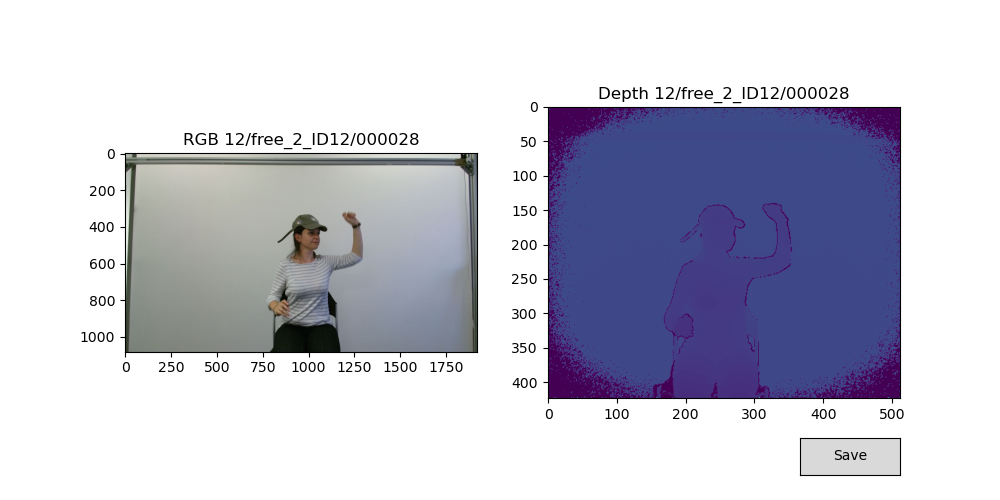

labels not complete
save


In [5]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import json
from tqdm import tqdm
from IPython.display import display

def onclick(event):
    global ax1, ax2, fig, rgb_coords, depth_coords

    if event.button == 3:
        source = None
        if event.inaxes == ax1:
            source = "rgb"
            rgb_coords.append((event.xdata/1920, event.ydata/1080))
        elif event.inaxes == ax2:
            source = "depth"
            depth_coords.append((event.xdata/512, event.ydata/424))
        
        # Draw a circle on the image on the clicked coordinates
        if source == "rgb":
            ax1.plot(event.xdata, event.ydata, 'ro', markersize=2)
        elif source == "depth":
            ax2.plot(event.xdata, event.ydata, 'ro', markersize=2)

def save(event):
    global labels, path, rgb_coords, depth_coords
    
    if len(rgb_coords) == 8 and len(depth_coords) == 8:
        # Save the labels in the dictionary
        labels[path] = {"rgb": rgb_coords, "depth": depth_coords}

        with open("alignment_labels.json", "w") as file:
            file.seek(0)
            json.dump(labels, file, indent=4)
            file.truncate()
        print("save")
    else:
        print("labels not complete")

def load_files():
    dataset_path = "dataset/pandora/"
    image_paths = []
    subfolders = os.listdir(dataset_path)
    for subfolder in subfolders:
        subfolder_path = dataset_path + subfolder + "/"
        subsubfolders = os.listdir(subfolder_path)
        for subsubfolder in subsubfolders:
            subsubfolder_path = subfolder_path + subsubfolder + "/"
            rgb_folder_path = subsubfolder_path + "RGB/"
            depth_folder_path = subsubfolder_path + "DEPTH/"
            rgb_images = os.listdir(rgb_folder_path)
            depth_images = os.listdir(depth_folder_path)
            for i in range(len(rgb_images)):
                rgb_image_path = rgb_folder_path + rgb_images[i]
                depth_image_path = depth_folder_path + depth_images[i]
                image_paths.append((rgb_image_path, depth_image_path))
    # Shuffle with a specific seed
    np.random.seed(0)
    np.random.shuffle(image_paths)
    return image_paths
           
def get_unique_path(path):
    path = rgb_image_path.split("/")[2:]
    path.pop(2)
    path[2] = path[2].split("_")[0]
    path = "/".join(path)
    return path


image_paths = load_files()
rgb_coords = []
depth_coords = []
path = None

with open("alignment_labels.json", "r") as file:
    try:
        labels = json.load(file)
    except json.JSONDecodeError:
        # If the file is empty or not valid JSON, initialize an empty dictionary
        labels = {}

# Iterate over the images
for images in tqdm(image_paths):
    rgb_image_path = images[0]
    depth_image_path = images[1]
    path = get_unique_path(rgb_image_path)

    if path in labels:
        print("path: ", path, " already labeled")
        continue
    break

rgb_image = cv2.imread(rgb_image_path, cv2.IMREAD_UNCHANGED)
rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)

depth_image = cv2.imread(depth_image_path, cv2.IMREAD_UNCHANGED)

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.canvas.mpl_connect('button_press_event', onclick)
axbutton = plt.axes([0.8, 0.05, 0.1, 0.075])
button = plt.Button(axbutton, 'Save')
button.on_clicked(save)

# Plot images
ax1.imshow(rgb_image)
ax2.imshow(depth_image)

# Plot title
ax1.set_title("RGB " + path)
ax2.set_title("Depth " + path)
# Show the plot
plt.show()
